## Test spherical spatial interpolators using Franke 3D evaluation function  
### Test functions
- http://www.sfu.ca/~ssurjano/franke2d.html  
- http://www.sciencedirect.com/science/article/pii/S037704270100485X  

### QR Factorization (Fornberg)
- http://epubs.siam.org/doi/abs/10.1137/060671991  
- http://epubs.siam.org/doi/abs/10.1137/09076756X  

### Initial nodes
- http://web.maths.unsw.edu.au/~rsw/Sphere/  
- http://math.boisestate.edu/~wright/montestigliano/nodes.zip  

In [1]:
import scipy.io
import numpy as np
import spatial_interpolators as spi
import matplotlib.pyplot as plt

### Franke's 3D evaluation function

In [2]:
def franke(x,y,z):
	F1 = 0.75*np.exp(-((9.*x-2.)**2 + (9.*y-2.)**2 + (9.0*z-2.)**2)/4.)
	F2 = 0.75*np.exp(-((9.*x+1.)**2/49. + (9.*y+1.)/10. + (9.0*z+1.)/10.))
	F3 = 0.5*np.exp(-((9.*x-7.)**2 + (9.*y-3.)**2 + (9.*z-5)**2)/4.)
	F4 = 0.2*np.exp(-((9.*x-4.)**2 + (9.*y-7.)**2 + (9.*z-5.)**2))
	F = F1 + F2 + F3 - F4
	return F

### Calculate Franke's evaluation function at nodal points

In [3]:
# using max_determinant nodal points from
# http://math.boisestate.edu/~wright/montestigliano/nodes.zip
N = 324
xd = scipy.io.loadmat('md{0:05d}.mat'.format(N))
x,y,z = xd['x'][:,0],xd['x'][:,1],xd['x'][:,2]
# compute functional values at nodes
f = franke(x,y,z)

### Calculate Franke's evaluation function at grid points

In [4]:
# convert node coordinates to lat/lon
lon,lat,_ = spi.spatial.to_sphere(x,y,z)

# calculate output points (standard lat/lon grid)
dlon = 5.0
dlat = 5.0
gridlon = np.arange(0,360+dlon,dlon)
gridlat = np.arange(90,-90-dlat,-dlat)
LON,LAT = np.meshgrid(gridlon,gridlat,indexing='ij')
x,y,z = spi.spatial.to_cartesian(LON,LAT,a_axis=1.0,flat=0.0)
# calculate functional values at output points
FI = franke(x, y, z)

### Interpolate to spherical grid

In [5]:
# interpolate with radial basis functions
m = 'gaussian'
RBF = spi.sph_radial_basis(lon,lat,f,LON,LAT,method=m,smooth=0.0001,
	epsilon=1.0)
QR = spi.sph_radial_basis(lon,lat,f,LON,LAT,method=m,epsilon=0.9,QR=True)
# interpolate with spherical splines
t = 2.
SPL = spi.sph_spline(lon,lat,f,LON,LAT,tension=t)

### Create output plot showing interpolation and points

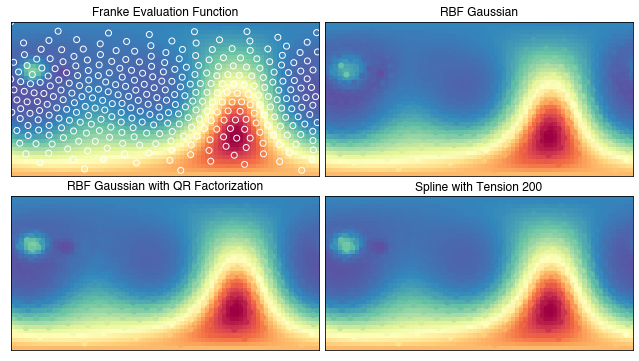

In [6]:
# plot interpolation and real-interpolated
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(num=1, ncols=2, nrows=2,
	sharex=True, sharey=True, figsize=(9,4.9))
cmap = plt.cm.get_cmap('Spectral_r').copy()
cmap.set_bad('w',0.)

ax1.scatter(lon, lat, c=f, vmin=f.min(), vmax=f.max(),
	cmap=cmap, edgecolors='w')
ax1.imshow(FI.transpose(),extent=(0,360,-90,90),
	vmin=f.min(), vmax=f.max(), cmap=cmap)
ax2.imshow(RBF.transpose(),extent=(0,360,-90,90),
	vmin=f.min(), vmax=f.max(), cmap=cmap)
ax2.scatter(lon, lat, c=f, vmin=f.min(), vmax=f.max(),
	cmap=cmap, edgecolors='none')
ax3.imshow(QR.transpose(),extent=(0,360,-90,90),
	vmin=f.min(), vmax=f.max(), cmap=cmap)
ax3.scatter(lon, lat, c=f, vmin=f.min(), vmax=f.max(),
	cmap=cmap, edgecolors='none')
ax4.imshow(SPL.transpose(),extent=(0,360,-90,90),
	vmin=f.min(), vmax=f.max(), cmap=cmap)
ax4.scatter(lon, lat, c=f, vmin=f.min(), vmax=f.max(),
	cmap=cmap, edgecolors='none')

# for each axis
for ax in [ax1,ax2,ax3,ax4]:
    # no ticks on the x and y axes
	ax.get_xaxis().set_ticks([])
	ax.get_yaxis().set_ticks([])
	# set x and y limits (global)
	ax1.set_xlim(0,360)
	ax1.set_ylim(-90,90)
 
# set titles
ax1.set_title('Franke Evaluation Function')
ax2.set_title('RBF {0}'.format(m.capitalize()))
ax3.set_title('RBF {0} with QR Factorization'.format(m.capitalize()))
ax4.set_title('Spline with Tension {0:0.0f}'.format(t*100))
# subplot adjustments
fig.subplots_adjust(left=0.02,right=0.98,bottom=0.01,top=0.95,
	wspace=0.02,hspace=0.11)
plt.show()